Data already exists.
Data already exists.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_train.pkl
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_test.pkl
(50000, 2048)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Iteration: 0 Training accuracy: 0.25 Training loss: 4.6323833
Iteration: 100 Training accuracy: 0.90625 Training loss: 0.30084
Iteration: 200 Training accuracy: 0.9140625 Training loss: 0.33398062
Iteration: 300 Training accuracy: 0.9375 Traini

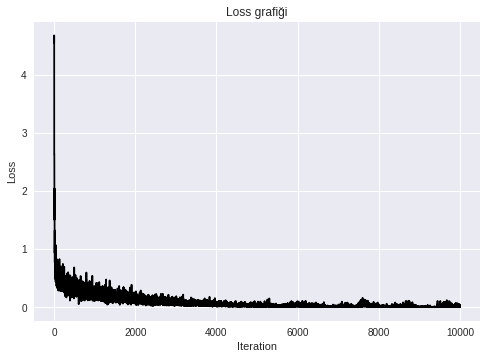

In [7]:
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from datetime import timedelta

from google.colab import files
#src = list(files.upload().values())[0]    # add a new lib from computer
#open('mylib.py','wb').write(src)
#import mylib

#src = list(files.upload().values())[0]    # add a new lib from computer
#open('mylib.py','wb').write(src)
#import mylib

import cifar10
import inception

from cifar10 import num_classes
from inception import transfer_values_cache

cifar10.download()
inception.download()

#get model
model = inception.Inception()

#get cifar10 files
train_img, train_cls, train_labels = cifar10.load_training_data()
test_img, test_cls, test_labels = cifar10.load_test_data()

#input direk cifar10 olmıcak, cifar inception'dan geçirilip öyle input alıncak
#bunları harddiske yazdırıcam   # string toplaması
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

#color value range is between 0 and 255 at inception 
#but it is between 0 and 1 at cifar10
# multiply cifar10 * 255
images_scaled = train_img * 255.0

#transfer değerleri önceden hesaplandıysa yükle yoksa hesapla
#cache, yazılan yer;resimlerimiz;modelimiz
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                             images=images_scaled,
                                             model=model)

images_scaled = test_img * 255.0
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

#transfer değerlerinin boyutuna bakalım
print(transfer_values_train.shape)  # 50k 2048
# 50k cifar10 eğitim setindeki resim sayısı  
# 2048 ise önceki layer'ın nöron sayısı (gelen transfer değerleri)

x = tf.placeholder(tf.float32, [None, 2048])
y_true = tf.placeholder(tf.float32, [None, num_classes])#num_classes, class sayısı yani 10 yani çıktı sayısı

weight1 = tf.Variable(tf.truncated_normal([2048, 1024], stddev=0.1))
bias1 = tf.Variable(tf.constant(0.1, shape=[1024]))
weight2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
bias2 = tf.Variable(tf.constant(0.1, shape=[10]))

y1 = tf.nn.relu(tf.matmul(x, weight1) +  bias1)
logits = tf.matmul(y1, weight2) + bias2
y2 = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y2, 1)   #tahmin edilen sınıf için değişken oluşturuyoruz


##COPY PASTE
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
loss = tf.reduce_mean(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y2, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(5e-4).minimize(loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

batch_size = 128
def random_batch():
    num_images = len(transfer_values_train)
    idx = np.random.choice(num_images, size=batch_size, replace=False)
    x_batch = transfer_values_train[idx]
    y_batch = train_labels[idx]

    return x_batch, y_batch


loss_graph = []
def training_step (iterations):
    start_time = time.time()
    for i in range (iterations):
        x_batch, y_batch = random_batch()
        feed_dict_train = {x: x_batch, y_true: y_batch}
        [_, train_loss] = sess.run([optimizer, loss], feed_dict=feed_dict_train)
        loss_graph.append(train_loss)

        if i % 100 == 0:
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            print('Iteration:', i, 'Training accuracy:', acc, 'Training loss:', train_loss)

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: ", timedelta(seconds=int(round(time_dif))))


batch_size_test = 256
def test_accuracy():
    num_images = len(transfer_values_test)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0
    while i < num_images:
        j = min(i + batch_size_test, num_images)
        feed_dict = {x: transfer_values_test[i:j],
                     y_true: test_labels[i:j]}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (test_cls == cls_pred)
    print('Testing accuracy:', correct.mean())

training_step(10000)
test_accuracy()

plt.plot(loss_graph, 'k-')
plt.title('Loss grafiği')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
  






